## **IT3212 - Assignment 2 - Group 25**
**Developers:** *Thomas Haugan, David Spilde, Anders Stubberud and Erlend Løken Sæveraas*

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from IPython.display import display, HTML
from sklearn.decomposition import PCA

from skimage import color, data
from skimage.feature import hog
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
import os


warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

---
## **Fourier Transform (20 points)**

**Load a grayscale image and apply the 2D Discrete Fourier Transform (DFT) to it. Visualize the original image and its frequency spectrum (magnitude). Submit the images, and explanation**

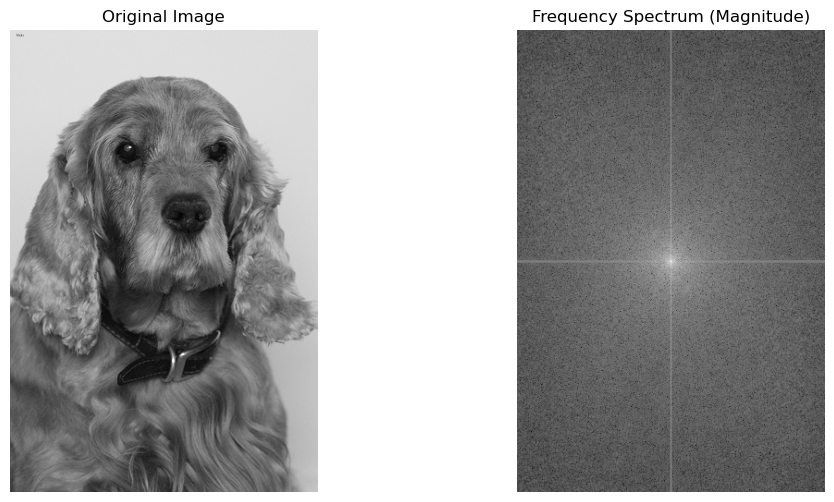

In [8]:
image_path = '../data/oxford-iiit-pet/images/english_cocker_spaniel_13.jpg'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply the 2D Discrete Fourier Transform (DFT)
dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)  # Shift the zero frequency component to the center

# Compute the magnitude spectrum
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

# Plot the original image and the magnitude spectrum
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Magnitude Spectrum (Frequency Spectrum)
plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Frequency Spectrum (Magnitude)')
plt.axis('off')
plt.show()

**Explanation**
<br>
The 2D Fourier transform comes in handy for image processing since the representation in the frequency domain enables several neat techniques, easing processes such as edge detection, texture recognition, noise reduction, and compression.

Here, the discrete Fourier transform takes as input a greyscale image represented in the spacial domain, where the values are the intensities of the pixels in the image. The output is the image represented in the frequency domain, showing the decomposition of constituent frequencies.\\
Depicted in the center of the frequency spectrum in above figure is the direct current component, often referred to as DC. DC represents the (0, 0) frequency term, which is made up of the sum of all pixel intensities in the original image, thus representing the average brightness. This average value is typically fairly large for images. Furthermore, the background of this image is practically homogeneous, further contributing with low frequencies. The strong presence of low frequencies result in a bright spot at and around the center of the frequency spectrum.

Contrary, the high frequencies represent rapid changes in pixel intensities, and are located towards the boundaries of the frequency spectrum. In this image, high frequencies are necessary to reflect the sharp change in pixel intensities occurring at areas such as the border between the light fur and the dark collar. The high frequencies are visible as the medium-bright horizontal and vertical lines. 

**Implement a low-pass filter in the frequency domain to remove high-frequency noise from an image. Compare the filtered image with the original image. Submit images, and analysis of the results**

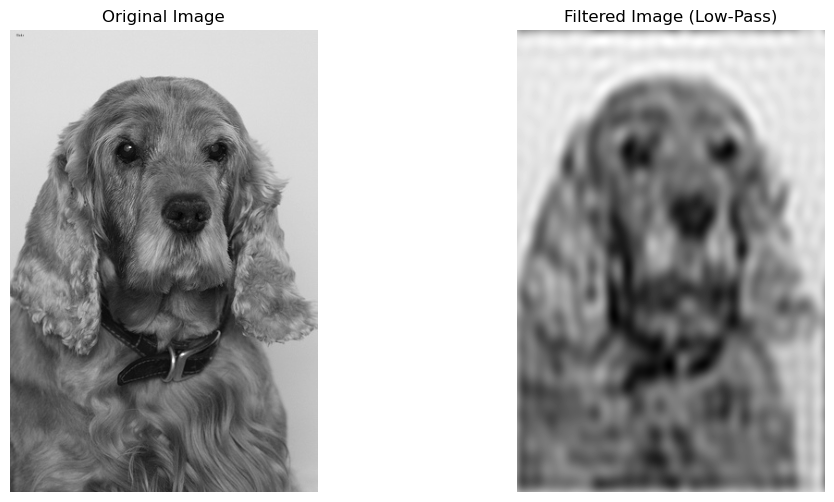

In [9]:
# Create a low-pass filter mask
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2  # Center of the image
radius = 20  # Adjust radius as needed for filtering
mask = np.zeros((rows, cols, 2), np.uint8)
cv2.circle(mask, (ccol, crow), radius, (1, 1), thickness=-1)  # Create a circular mask

# Apply the mask to the DFT
filtered_dft_shift = dft_shift * mask

# Inverse DFT to get the filtered image
filtered_dft_shift_ishift = np.fft.ifftshift(filtered_dft_shift)
filtered_image = cv2.idft(filtered_dft_shift_ishift)
filtered_image_magnitude = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

# Plot the original image and the filtered image
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Filtered Image
plt.subplot(1, 2, 2)
plt.imshow(filtered_image_magnitude, cmap='gray')
plt.title('Filtered Image (Low-Pass)')
plt.axis('off')
plt.show()

**Analysis of results**
<br>
Low-pass filters are used to remove noise in the image, which can be defined as: random variation of brightness or color information in the images captured. Thus, for gray scale images, noise can be viewed as random variation in pixel intensity. Intuitively, it is desirable to reduce the noise. Pixels with intensities deviating significantly from nearby pixels (such as is the result with random variation) will be represented by a high frequency component, since high frequencies signify rapid changes in pixel intensities. Thus, to eliminate noise, low-pass filters eliminate frequencies above a certain threshold in the frequency spectrum.

Comparing the original image with it's low-pass filter counterpart in the figure, it's apparent that the image is blurred and smoothed out. Finer details such as edges and textures are no longer as prominent. This is a by-product of the low-pass filter; sharp changes in pixel intensities are represented by high frequencies whether they originate from noise or not, and is thus at risk of being removed by the filter.

**Implement a high-pass filter to enhance the edges in an image. Visualize the filtered image and discuss the effects observed. Submit images, and explanation**


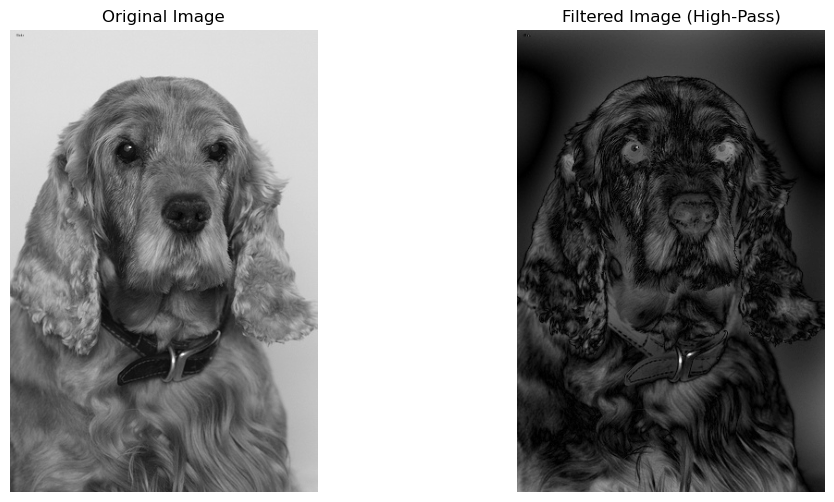

In [10]:
dft_result = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shifted = np.fft.fftshift(dft_result)  # Shift the zero frequency component to the center

# Create a mask for high-pass filtering
rows, cols = image.shape
center_row, center_col = rows // 2, cols // 2  # center

# Create a circular mask for low frequencies
radius = 2.5  # Adjust this value for desired cut-off frequency
x, y = np.ogrid[:rows, :cols]
mask = (x - center_row) ** 2 + (y - center_col) ** 2 <= radius ** 2
dft_shifted[mask] = 0  # Set the low frequencies to zero for high-pass filtering

# Apply the inverse shift before the inverse DFT
dft_shifted = np.fft.ifftshift(dft_shifted)

# Apply the inverse DFT to get the high-pass filtered image
high_pass_filtered_image = cv2.idft(dft_shifted)
high_pass_filtered_image = cv2.magnitude(high_pass_filtered_image[:, :, 0], high_pass_filtered_image[:, :, 1])

# Normalize the filtered image for display
high_pass_filtered_image = cv2.normalize(high_pass_filtered_image, None, 0, 255, cv2.NORM_MINMAX)
high_pass_filtered_image = np.uint8(high_pass_filtered_image)

# Plot the original image and the high-pass filtered image
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# High-Pass Filtered Image
plt.subplot(1, 2, 2)
plt.imshow(high_pass_filtered_image, cmap='gray')
plt.title('Filtered Image (High-Pass)')
plt.axis('off')
plt.show()

**Discussion of observed effects**
<br>
 Contrary to low-pass filters, high-pass filters keeps frequency components above a certain frequency threshold, while attenuating the strength of frequencies below it.
 Consequently, as higher frequencies to a greater extent dominate the frequency spectrum, finer details such as edges and textures will be more prominent. Therefore, this technique serves useful for applications such as edge detection and texture recognition.

Visualizing the high-pass filtered image in above figure illustrates the effects; certain finer details, such as the dog's pupils, are far more pronounced than in the original image. Furthermore, frequencies constituted by homogeneous areas from the original image, such as the lightly-colored background, have clearly diminished in strength, appearing much darker.

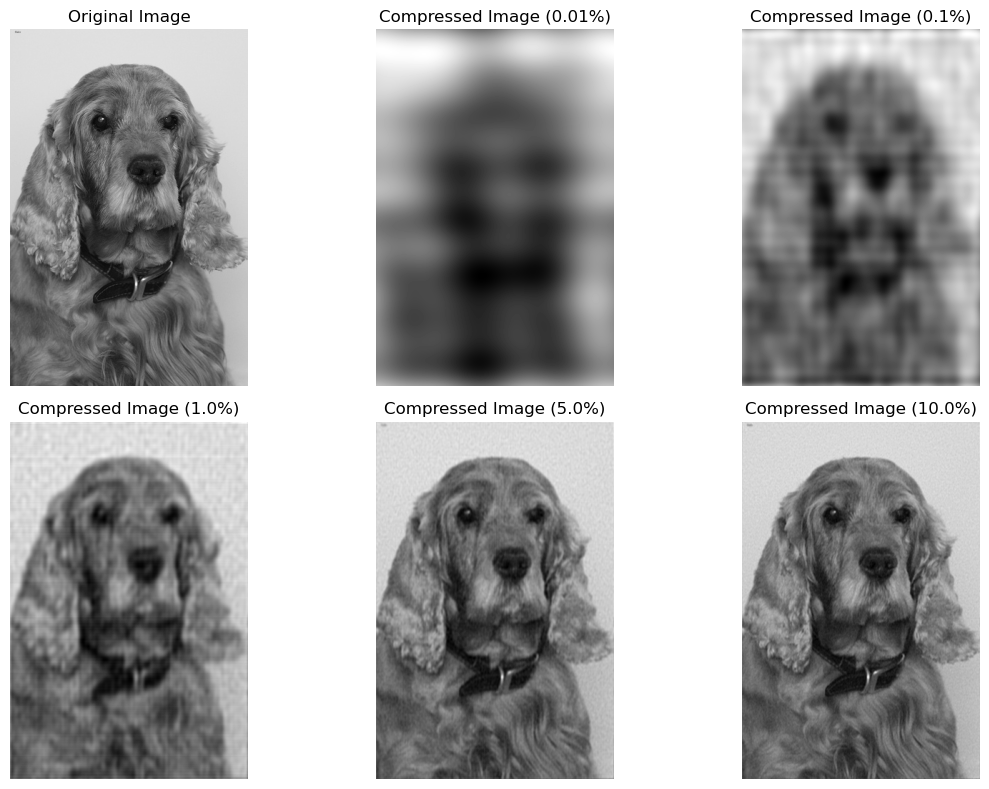

In [11]:
def compress_image_with_dft(image, keep_percentage):
    # Apply the 2D Discrete Fourier Transform (DFT)
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift the zero frequency component to the center

    # Get the magnitude and phase of the Fourier coefficients
    magnitude_spectrum = np.abs(dft_shift)
    phase_spectrum = np.angle(dft_shift)

    # Flatten the magnitude and find the threshold for keeping the largest coefficients
    flattened_magnitude = magnitude_spectrum.flatten()
    sorted_magnitude = np.sort(flattened_magnitude)
    threshold = sorted_magnitude[int((1 - keep_percentage) * len(sorted_magnitude))]

    # Create a mask to zero out coefficients below the threshold
    magnitude_mask = magnitude_spectrum >= threshold

    # Apply the mask to keep only the selected percentage of coefficients
    compressed_dft_shift = dft_shift * magnitude_mask

    # Reconstruct the image from the compressed DFT
    compressed_dft = np.fft.ifftshift(compressed_dft_shift)  # Inverse shift
    compressed_image = cv2.idft(compressed_dft)
    compressed_image = cv2.magnitude(compressed_image[:, :, 0], compressed_image[:, :, 1])  # Get the magnitude

    return compressed_image

# Load the image
image_path = '../data/oxford-iiit-pet/images/english_cocker_spaniel_13.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Compress the image with different percentages of Fourier coefficients
percentages = [0.0001, 0.001, 0.01, 0.05, 0.1]  # 10%, 30%, 50%
compressed_images = [compress_image_with_dft(image, p) for p in percentages]

# Plot the original image and the compressed images
plt.figure(figsize=(12, 8))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Compressed Images
for i, (p, comp_img) in enumerate(zip(percentages, compressed_images), start=2):
    plt.subplot(2, 3, i)
    plt.imshow(comp_img, cmap='gray')
    plt.title(f'Compressed Image ({p*100}%)')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Observations on image quality and compression ratio**
<br>
Digital images may contain redundant data in the form of highly correlated pixels not noticeable by the human eye. Since these finer details have a rather small impact on the overall appearance of the image, they can be discarded while preserving acceptable visual quality in the image. Transforming the image to the frequency domain and keeping only a set percentage of the most dominating frequency coefficients in terms of magnitude can thus compress the image.

Figure above depicts the original image along with five images with varying percentage of retained coefficients. 
Keeping only 0.01\%-0.1\% of the coefficients shows a significant decrease in visual quality, which can be accredited to the lack of details such as edges and textures which were represented by high frequencies of low magnitude.

Retaining 1\% has evidently preserved some mid- and higher frequency components, as there now is some granularity visible in the image. 
At 5\% or more, The frequency coefficients responsible for details visible to the human eye are presumably preserved, as there is no distinguishable difference from the original image. This demonstrates that a significant portion of the image's data can be discarded without noticeable effect on image quality.

---
## **PCA (25 points)**

### **Select a set of grayscale images (e.g., faces, landscapes, or any other category). Normalize the images by scaling pixel values to a range [0, 1]**

The images used in this tasks are taken from the FER-2013 grayscale facial image dataset, available at https://www.kaggle.com/datasets/msambare/fer2013?resource=download. The dataset is divided into categories based on the emotion exressed in the faces on the images, whereas all the images used in this task are from the happy category. This accounts for a grand total of 7215 images at $(48 \times 48)$ pixels.

In [13]:
# Function to load images without resizing and skipping portrait images
def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return np.array(images)

# Load images
folder_path = '../data/archive/train/happy'
images = load_images(folder_path)
print(f"Loaded {len(images)} images with shape {images[0].shape}")


Loaded 7215 images with shape (48, 48)


### **Convert the image into a 2D matrix where each row represents an image and each column represents a pixel value**

Prior to the conversion, we made sure to check that all images had the same height and width, in order to be certain all of them would fit into the matrix. The reason as to why we went for rather small images, at a height and width of 48 pixels, was based on the observation that larger dimensions significantly slowed down calculations, such as finding eigenvectors and eigenvalues. Such small dimensions does indeed put a restraint on the quality of the original images, however, we deemed this a necessary step to produce results in a reasonable time. 
Thus, the resulting 2D matrix has the shape of $(7215 \times 2304)$.

In [14]:
# Flatten the images to 2D matrix (num_images, num_pixels)
image_matrix = images.reshape(images.shape[0], -1)  # num_images x (height * width)
print(f"Image matrix shape: {image_matrix.shape}")

Image matrix shape: (7215, 2304)


### **Compute the covariance matrix of the image data**

The covariance matrix expresses how the pixel values across the different images change in relation to each other. Since each image has a total of 2304 pixels, whereas the matrix needs to express each pixel's variance in relation to every other pixel, the covariance matrix has the shape of $(2304\times2304)$.

In [15]:
# Compute the covariance matrix
cov_matrix = np.cov(image_matrix, rowvar=False)  # Columns represent variables (pixels)
print(f"Covariance matrix shape: {cov_matrix.shape}")

Covariance matrix shape: (2304, 2304)


### **Calculate the eigenvalues and eigenvectors of the covariance matrix**

Eigenvectors and their corresponding eigenvalues are used to determine the principal components of the data, which are used to retain the dimensions of maximum variance (and thus valuable information). The eigenvalues quantifies the amount of variance in the direction of their corresponding eigenvector, whereas the eigenvectors expresses the patterns, or directions, across pixels in the image.

While the covariance matrix has $n \times n$ dimensions, whereas in this particular case $n = 2304$, it can not necessarily describe 2304 independent directions in which the pixels varies. This is because the number of images sets a limit on the number of *independent* variations which can be captured. Thus, while there will be $n$ eigen components, the number of distinct eigenvectors will be determined by $\min(\text{number of pixels},\ \text{number of images})$. In this case, however, the number of pixels per image, 2304 is in fact smaller than the number of images 7215, thus there will be 2304 distinct eigenvectors which can represent the principal components.

In [16]:
# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print(f"Eigenvalues shape: {eigenvalues.shape}, Eigenvectors shape: {eigenvectors.shape}")

Eigenvalues shape: (2304,), Eigenvectors shape: (2304, 2304)


### **Sort the eigenvectors based on the eigenvalues in descending order**

By sorting the eigenvectors in descending order based on the value of their corresponding eigenvalue, PCA can select the eigenvectors which have the largest corresponding eigenvalue, which works to retain the dimensions of maximum variance in the process of dimensionality reduction.

In [17]:
# Sort eigenvectors based on eigenvalues in descending order
idx = np.argsort(eigenvalues)[::-1]
sorted_eigenvectors = eigenvectors[:, idx]
sorted_eigenvalues = eigenvalues[idx]

### **Select the top k eigenvectors to form the principal components**

By selecting the top k eigenvectors, for then to project the original data onto these, PCA is able to transform the data into a lower dimension while retaining as much variance (which is where the valuable information lies) as possible.

In [18]:
# Select top k principal components
# Number of components needed to explain 95% variance: 1125
# Number of components needed to explain 99% variance: 3349
k = len(sorted_eigenvalues) // 10  # Adjust based on the desired number of components
top_k_eigenvectors = sorted_eigenvectors[:, :k]
print(f"Selected top {k} eigenvectors shape: {top_k_eigenvectors.shape}")

Selected top 230 eigenvectors shape: (2304, 230)


### **Project the original images onto the lower-dimensional subspace defined by the selected principal components**

Projecting the images using the principal components results in a new representation of the images, now in the k-dimensional space. Thus, as dimension are reduced, so is the amount of memory needed to store the images, however, with the possible downside of reduced image quality to do removed data

In [19]:
# Project the original images onto the lower-dimensional subspace
projected_data = np.dot(image_matrix, top_k_eigenvectors)
print(f"Projected data shape: {projected_data.shape}")

Projected data shape: (7215, 230)


### **Using the selected principal components, reconstruct the images**

Transposing the principal components for then to project the reduced-dimensional data back to the original space reconstructs the images. Notably, the reconstructed images may deviate from the original's, due to loss of data during the transformation to a reduced-dimensional space.

In [20]:
reconstructed_images = np.dot(projected_data, top_k_eigenvectors.T).real.astype(np.float32)
reconstructed_images = reconstructed_images.reshape(images.shape)  # Reshape to original image dimensions

### **Compare the reconstructed images with the original images to observe the effects of dimensionality reduction**

Depicted in figure below is the comparison of 3 original images, along with their PCA-reduced and reconstructed counterparts. Here, the top 10\% principal components were used. Clearly, dimensionality reduction has to various extents affected the quality on the images. Even though the reconstructed versions of image 1 and 2 has to a somewhat decent extend preserved the characteristics of the originals, image 3's reconstruction is somewaht more obscured. 

This could be possibly be credited to image 1 and 2 having their most prominent characteristic represented by the principal components, while such is not the case for image 3.

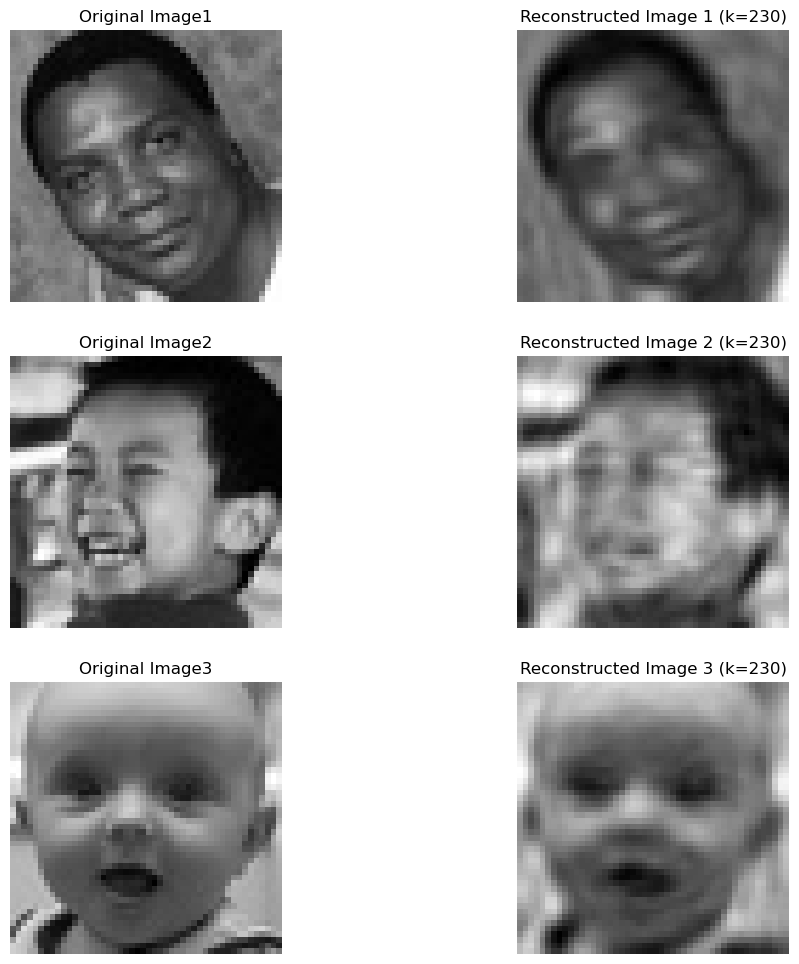

In [21]:
# Number of images to display
num_images_to_display = 3

# Create a figure with subplots
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(12, 4 * num_images_to_display))

for i in range(num_images_to_display):
    # Original image
    axes[i, 0].imshow(images[i + 420 + 17], cmap='gray')
    axes[i, 0].set_title('Original Image' + str(i + 1))
    axes[i, 0].axis('off')
    
    # Reconstructed image
    axes[i, 1].imshow(reconstructed_images[i + 420 + 17], cmap='gray')
    axes[i, 1].set_title(f'Reconstructed Image {str(i + 1)} (k={k})')
    axes[i, 1].axis('off')

# Adjust layout
# plt.tight_layout()
plt.show()

### **Vary the number of principal components (k) and observe the impact on the quality of the reconstructed images**

As depicted in figure below the number of principal components used does indeed impact the quality of the reconstructed images. Using a mere 10 principal components, accounting for just 0.43\% of the original components, shows an interesting result; the reconstructed image appears rather similar for all 3 images, even though their originals are quite different. This can be accredited to the first principal components representing the common structure among the images, thus excluding finer details accounting for the nuances in the individual images. Increasing the number of principal components increases the level of detail in the data, which in turn is reflected in the quality of the images. 

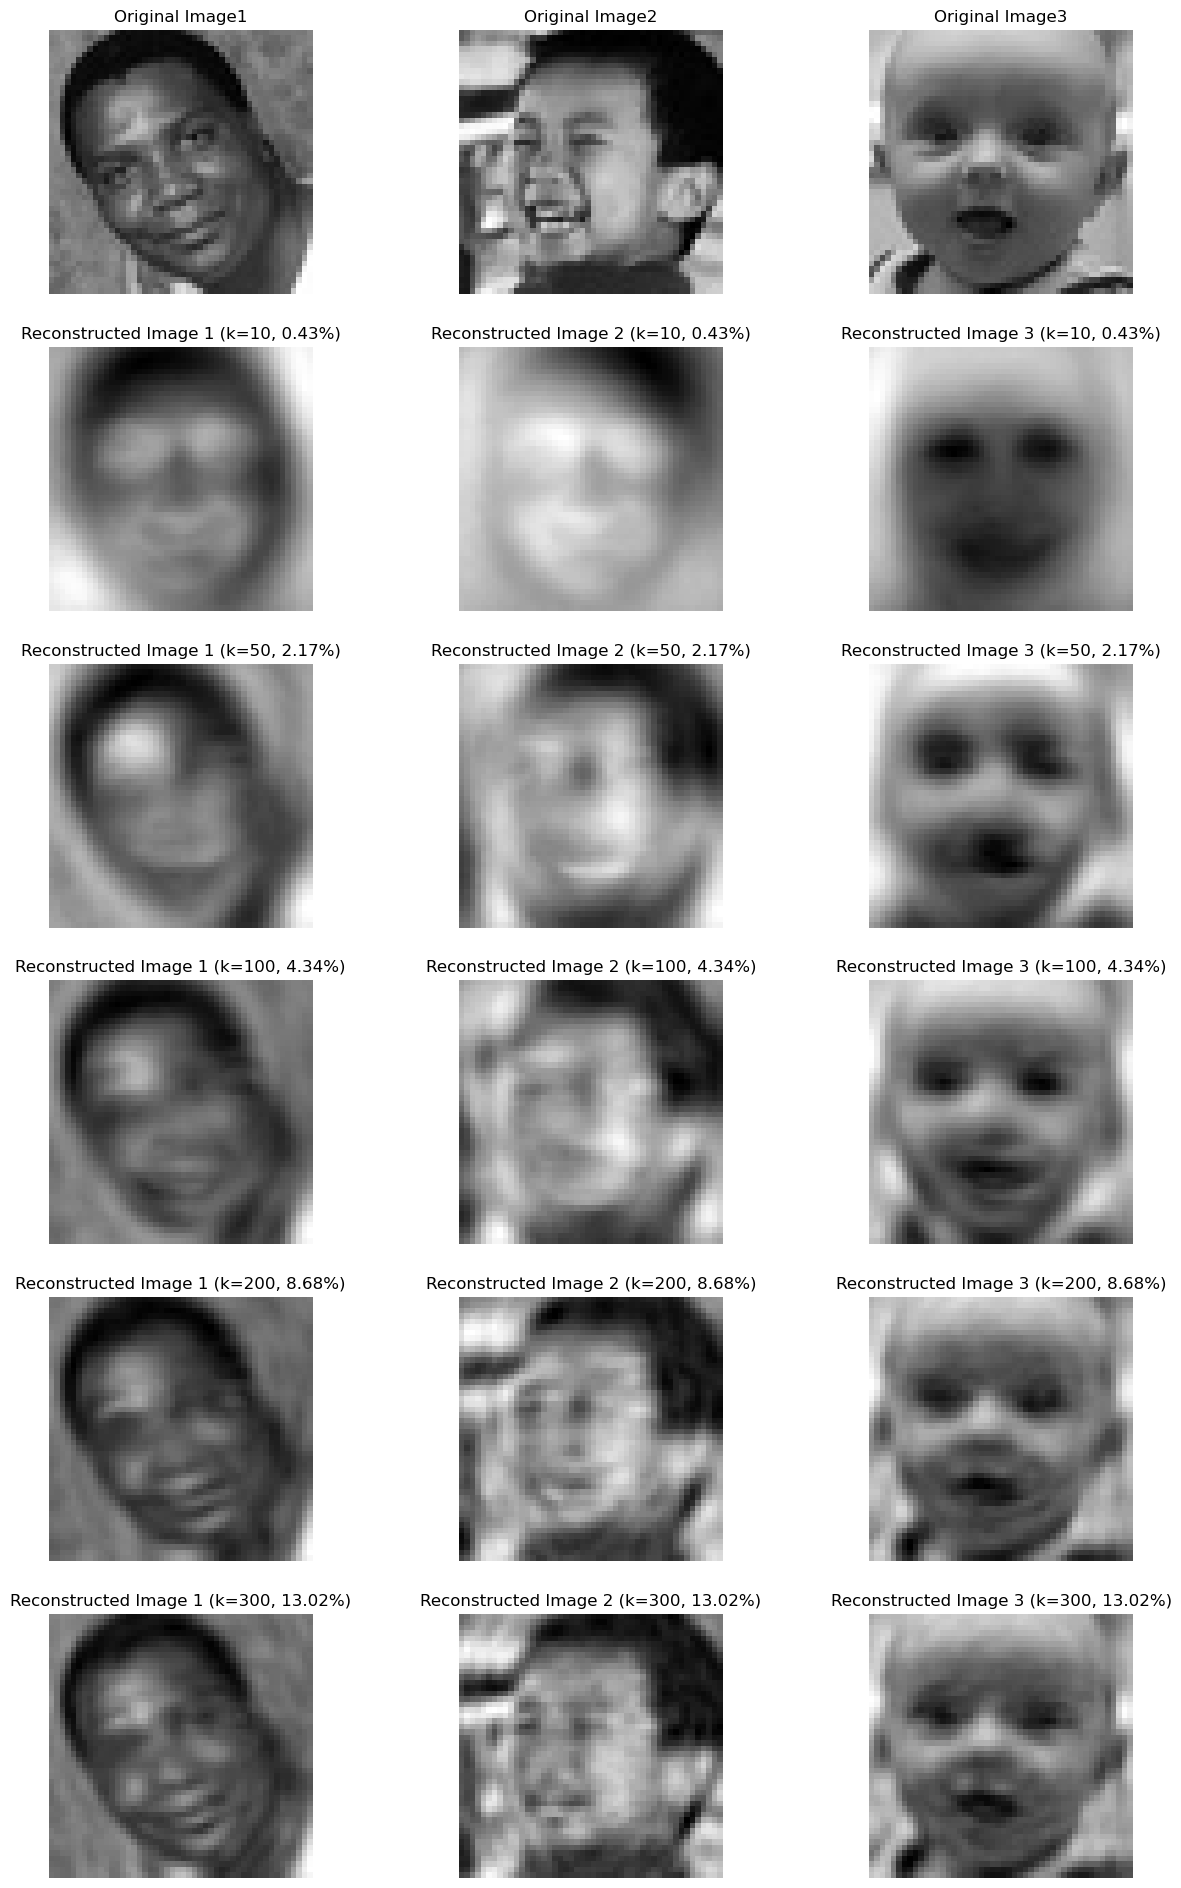

In [22]:
def vary(k_values):
    num_images_to_display = 3
    num_k_values = len(k_values)
    total_components = len(sorted_eigenvalues)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_k_values + 1, num_images_to_display, figsize=(5 * num_images_to_display, 4 * (num_k_values + 1)))
    
    for i in range(num_images_to_display):
        # Display original image
        axes[0, i].imshow(images[i + 420 + 17], cmap='gray')
        axes[0, i].set_title('Original Image' + str(i + 1))
        axes[0, i].axis('off')
        
        for j, k in enumerate(k_values):
            top_k_eigenvectors = sorted_eigenvectors[:, :k]
            projected_data = np.dot(image_matrix, top_k_eigenvectors)
            reconstructed_images = np.dot(projected_data, top_k_eigenvectors.T).real.astype(np.float32)
            reconstructed_images = reconstructed_images.reshape(images.shape)  # Reshape to original image dimensions
            
            # Calculate percentage of total components
            percentage = (k / total_components) * 100
            
            # Display reconstructed image
            axes[j + 1, i].imshow(reconstructed_images[i + 420 + 17], cmap='gray')
            axes[j + 1, i].set_title(f'Reconstructed Image {str(i + 1)} (k={k}, {percentage:.2f}%)')
            axes[j + 1, i].axis('off')
    
    plt.show()

# Example usage
k_values = [10, 50, 100, 200, 300] 
vary(k_values)

### **Plot the variance explained by the principal components and determine the optimal number of components that balances compression and qualit**

The optimal number of principal components used should strike a balance between compression (number of principals components used), and the quality of the reconstructed image. Intuitively, the number of principal components used should be small, while the variance explained by these principal components is large. This raises the question as to where the cumulative explained variance experiences diminishing returns.

Figure below shows the cumulative explained variance expressed by the number of principal components used. Clearly, the majority of variance is explained solely by the very first principal components. Furthermore, the variance stagnates rather fast. Thus, past a certain threshold, the increased quality from adding more principal components may not outweigh the cost in terms of losing out on compression.

Some sources suggest the 95th percentile of explained variance as a reasonable threshold. Plotting the line representing the 95th percentile in the figure shows this suggestion is a somewhat reasonable threshold; around this threshold, the explained variance stagnates significantly. For comparison, the lines for the 80th and 99th percentile are also plotted. The 80th percentile clearly has more variance to gain with the addition of a few more principal components, whereas the 99th percentile only provides a slight increase in variance, at the cost of a significant amount of principal components. Thus, while there may not be a perfect optimal number of principal components, we have opted to use the number of principal components which retain 95\% of the variance. In this case, that number comes out at 246.

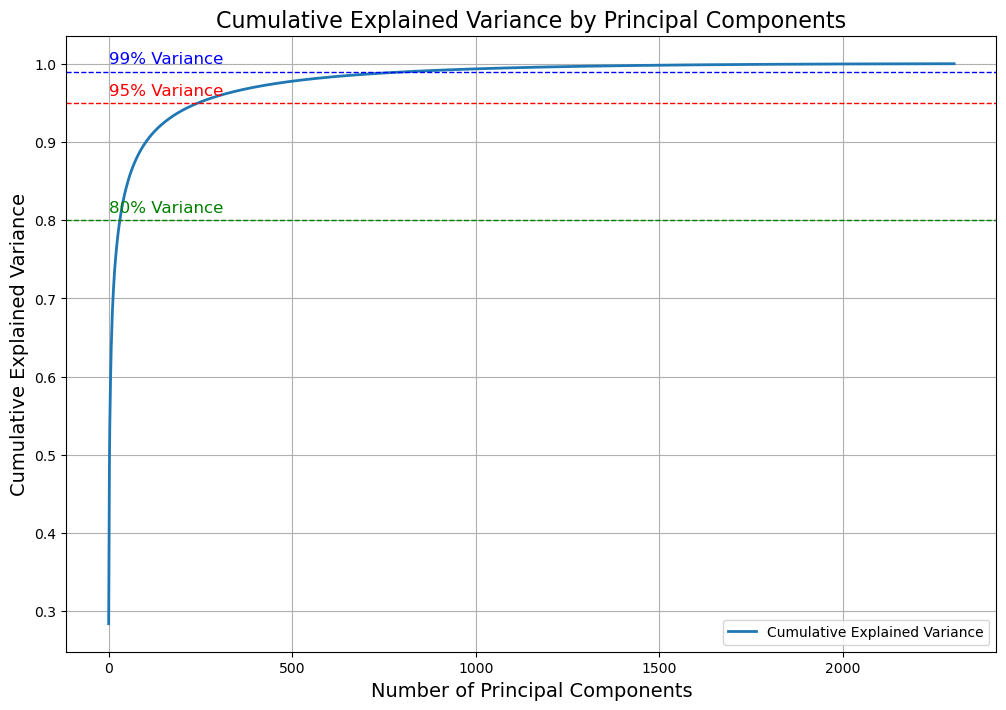

Number of components needed to explain 80% variance: 32
Number of components needed to explain 95% variance: 246
Number of components needed to explain 99% variance: 822


In [23]:
# Step 1: Apply PCA
pca = PCA()
pca.fit(image_matrix)

# Step 2: Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Step 3: Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Step 4: Plot cumulative explained variance
plt.figure(figsize=(12, 8))
plt.plot(cumulative_explained_variance, linestyle='-', linewidth=2, label='Cumulative Explained Variance')

# Add horizontal lines for 80%, 95%, and 99% variance explained
plt.axhline(y=0.80, color='g', linestyle='--', linewidth=1)
plt.text(0.5, 0.81, '80% Variance', color='green', fontsize=12)

plt.axhline(y=0.95, color='r', linestyle='--', linewidth=1)
plt.text(0.5, 0.96, '95% Variance', color='red', fontsize=12)

plt.axhline(y=0.99, color='b', linestyle='--', linewidth=1)
plt.text(0.5, 1.00, '99% Variance', color='blue', fontsize=12)

# Add labels and title
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.title('Cumulative Explained Variance by Principal Components', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Step 5: Determine the optimal number of components for 80%, 95%, and 99% variance
optimal_components_80 = np.argmax(cumulative_explained_variance >= 0.80) + 1
optimal_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
optimal_components_99 = np.argmax(cumulative_explained_variance >= 0.99) + 1

print(f'Number of components needed to explain 80% variance: {optimal_components_80}')
print(f'Number of components needed to explain 95% variance: {optimal_components_95}')
print(f'Number of components needed to explain 99% variance: {optimal_components_99}')


### **Display the original images alongside the reconstructed images for different values of k**

Figure below serves for comparing the quality and lost information of the reconstructed images with the thresholds for cumulative explained variance in Figure below. Using 32 principal components, retaining 80\% of the variance, the visual quality of the images is notably impacted. This can be accredited to a significant chunk of the finer details being lost in compression. Bumping the number of principal components up to 246, retaining 95\% of the variance, drastically improves the visual quality. Now, there is a clear resemblance between the original and reconstructed images. At 822 principle components, retaining 99\% of the variance, it is possible to notice even a bit more granularity as compared to 95\%. Nonetheless, this improvement requires almost 4 times the amount of principle components, raising the question as to whether or not the improved visual quality is worth the cost.

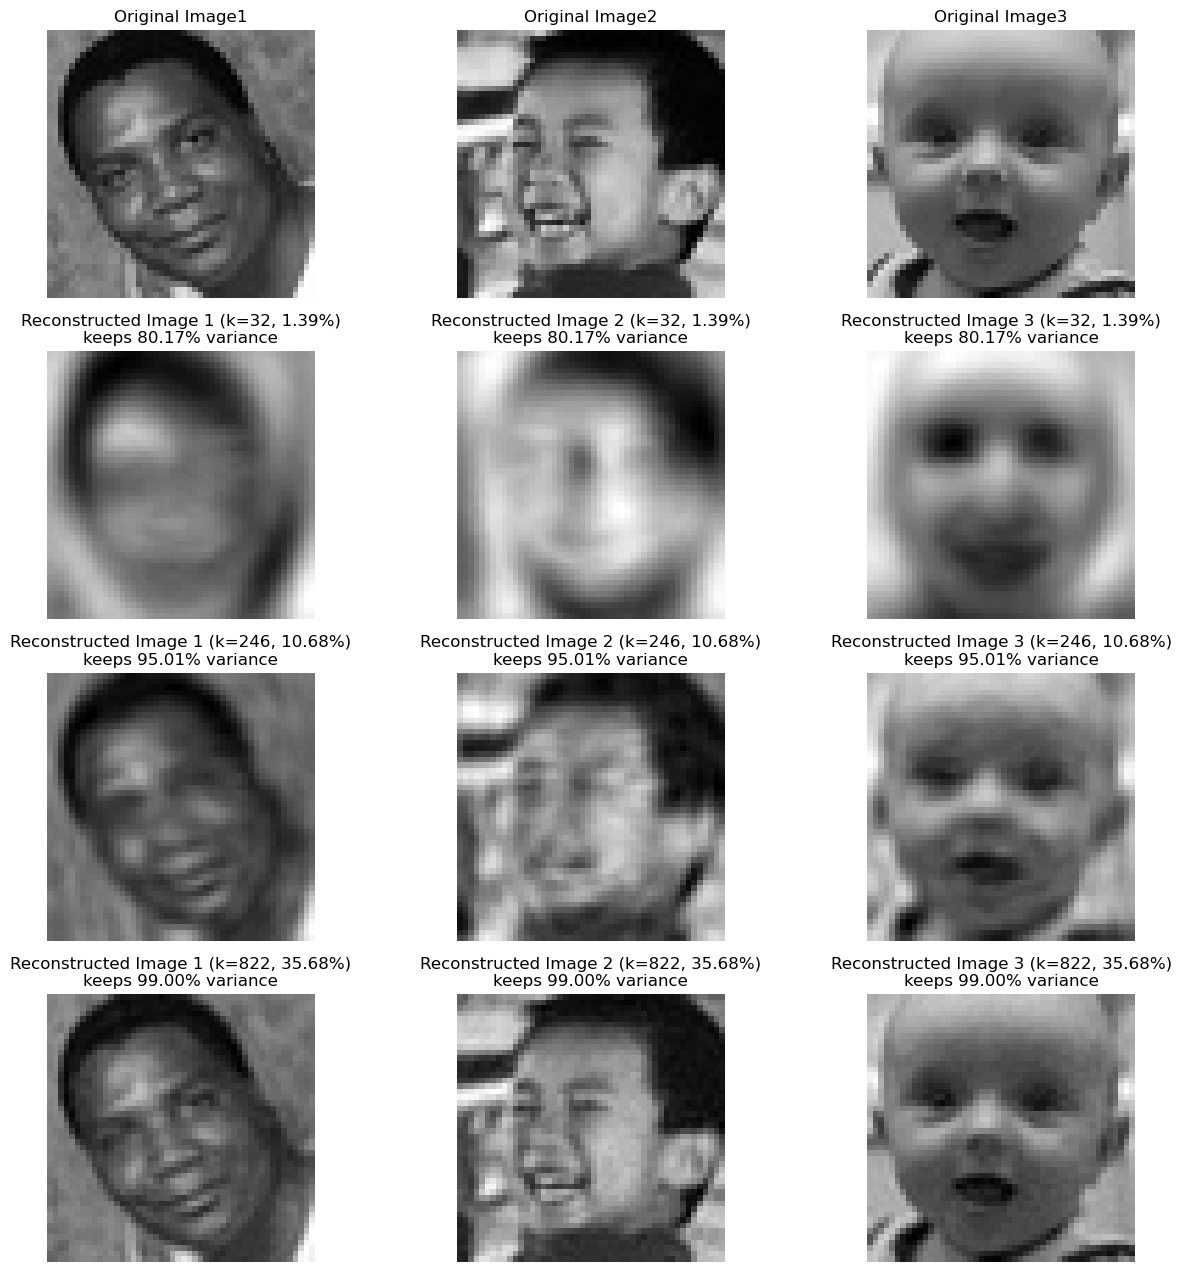

In [24]:
def vary(k_values):
    num_images_to_display = 3
    num_k_values = len(k_values)
    total_components = len(sorted_eigenvalues)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_k_values + 1, num_images_to_display, figsize=(5 * num_images_to_display, 4 * (num_k_values + 1)))
    
    for i in range(num_images_to_display):
        # Display original image
        axes[0, i].imshow(images[i + 420 + 17], cmap='gray')
        axes[0, i].set_title('Original Image' + str(i + 1))
        axes[0, i].axis('off')
        
        for j, k in enumerate(k_values):
            top_k_eigenvectors = sorted_eigenvectors[:, :k]
            projected_data = np.dot(image_matrix, top_k_eigenvectors)
            reconstructed_images = np.dot(projected_data, top_k_eigenvectors.T).real.astype(np.float32)
            reconstructed_images = reconstructed_images.reshape(images.shape)  # Reshape to original image dimensions
            
            # Calculate percentage of total components
            percentage = (k / total_components) * 100
            
            # Display reconstructed image
            axes[j + 1, i].imshow(reconstructed_images[i + 420 + 17], cmap='gray')
            axes[j + 1, i].set_title(f'Reconstructed Image {str(i + 1)} (k={k}, {percentage:.2f}%)\nkeeps {cumulative_explained_variance[k - 1] * 100:.2f}% variance')
            axes[j + 1, i].axis('off')
    
    plt.show()

# Example usage
k_values = [32, 246, 822] # 80, 95, and 99% variance explained
vary(k_values)

### **Compute the Mean Squared Error (MSE) between the original and reconstructed images**

Figure below depicts the computed mean square error (MSE) between the original images and their reconstructed counterparts. Evidently, more principal components results in a lower MSE, which also is reflected in the image quality. Figure expresses this transition more thoroughly, displaying the average MSE between all the reconstructed images and their corresponding original images for all possible value for k, the selected number of principal components. Clearly, the largest chunk of error is handled by the most dominating principal components, whereas further reductions results in diminishing returns.

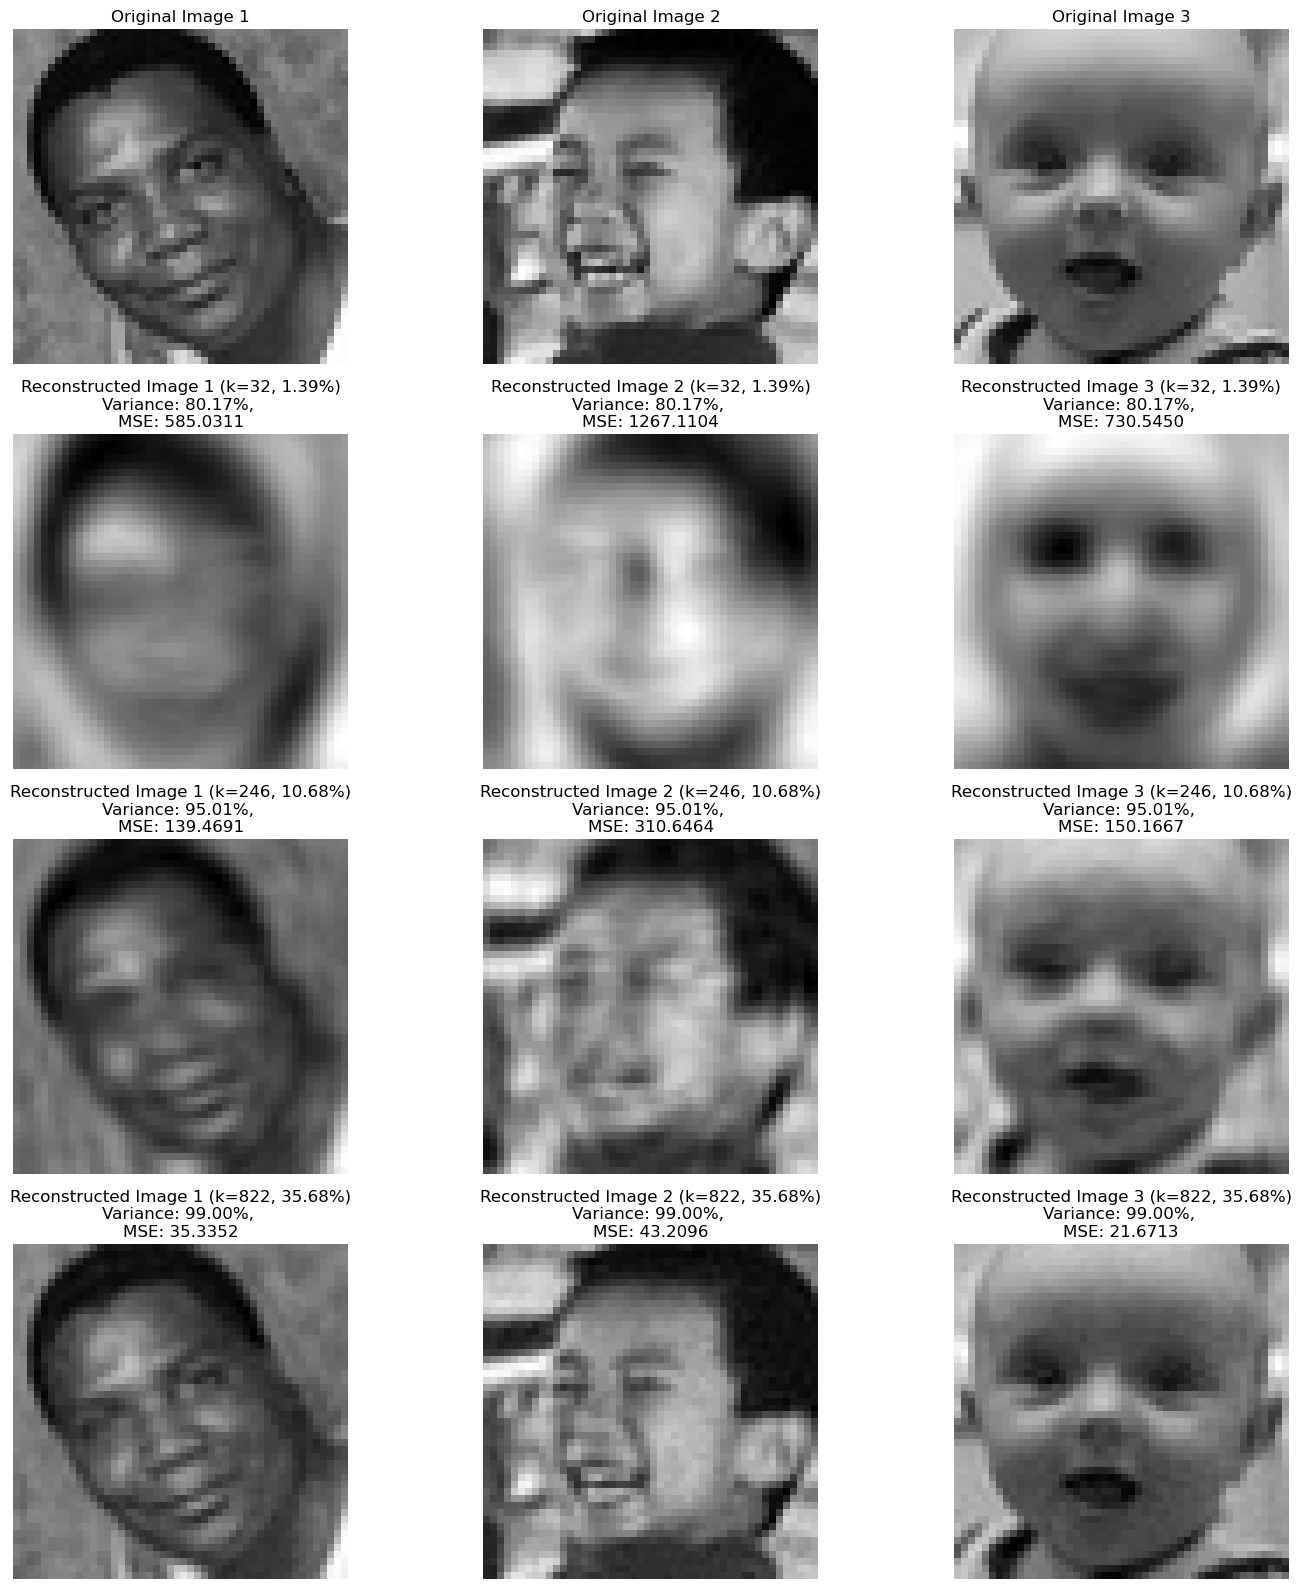

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def vary(k_values):
    num_images_to_display = 3
    num_k_values = len(k_values)
    total_components = len(sorted_eigenvalues)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_k_values + 1, num_images_to_display, figsize=(5 * num_images_to_display, 4 * (num_k_values + 1)))
    
    for i in range(num_images_to_display):
        # Display original image
        axes[0, i].imshow(images[i + 420 + 17], cmap='gray')
        axes[0, i].set_title('Original Image ' + str(i + 1))
        axes[0, i].axis('off')
        
        for j, k in enumerate(k_values):
            top_k_eigenvectors = sorted_eigenvectors[:, :k]
            projected_data = np.dot(image_matrix, top_k_eigenvectors)
            reconstructed_images = np.dot(projected_data, top_k_eigenvectors.T).real.astype(np.float32)
            reconstructed_images = reconstructed_images.reshape(images.shape)  # Reshape to original image dimensions
            
            # Calculate percentage of total components
            percentage = (k / total_components) * 100
            
            # Calculate MSE
            mse = np.mean((images[i + 420 + 17] - reconstructed_images[i + 420 + 17]) ** 2)
            
            # Display reconstructed image
            axes[j + 1, i].imshow(reconstructed_images[i + 420 + 17], cmap='gray')
            axes[j + 1, i].set_title(f'Reconstructed Image {str(i + 1)} (k={k}, {percentage:.2f}%)\nVariance: {cumulative_explained_variance[k - 1] * 100:.2f}%, \nMSE: {mse:.4f}')
            axes[j + 1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
k_values = [32, 246, 822]  # Adjust these values based on your variance needs
vary(k_values)

### **Analyze the trade-off between compression and reconstruction error**

Figure below expresses the trade-off between compression (i.e., the number of used principal components) and reconstruction error (MSE) more thoroughly. The plot shows the average MSE between all the reconstructed images and their corresponding original images for all possible value for k, the selected number of principal components. Clearly, the majority of error between the reconstructed and original images are handled by the most dominating principal components, whereas further gains result in diminishing returns. 

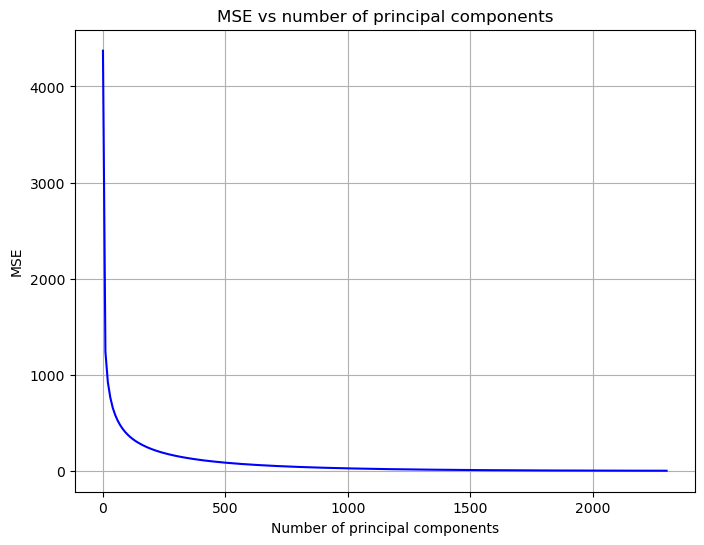

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate MSE for each k value
def calculate_mse(image_matrix, images, sorted_eigenvectors, k_values):
    mse_values = []
    
    # Loop through each k and calculate the MSE
    for k in k_values:
        # Select top k eigenvectors
        top_k_eigenvectors = sorted_eigenvectors[:, :k]
        
        # Project data onto the top k eigenvectors
        projected_data = np.dot(image_matrix, top_k_eigenvectors)
        
        # Reconstruct the images using the top k components
        reconstructed_images = np.dot(projected_data, top_k_eigenvectors.T).real.astype(np.float32)
        reconstructed_images = reconstructed_images.reshape(images.shape)  # Reshape to original image dimensions
        
        # Calculate the Mean Squared Error (MSE) between original and reconstructed images
        mse = np.mean((images - reconstructed_images) ** 2)
        mse_values.append(mse)
    
    return mse_values

# Function to plot MSE vs number of principal components
def plot_mse_vs_k(k_values, mse_values):
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, mse_values, color='blue')
    plt.title('MSE vs number of principal components')
    plt.xlabel('Number of principal components')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()

# Example usage
k_values = np.arange(1, 2304, 10)  # Choose a range of k values (number of principal components)
mse_values = calculate_mse(image_matrix, images, sorted_eigenvectors, k_values)
plot_mse_vs_k(k_values, mse_values)


---
## **HOG Features (12 points)**

**(1) Write a Python script to compute the HOG features of a given image using a library such as OpenCV or scikit-image<br>
(2) Apply your implementation to at least three different images, including both simple and complex scenes<br>
(3) Visualize the original image, the gradient image, and the HOG feature image**

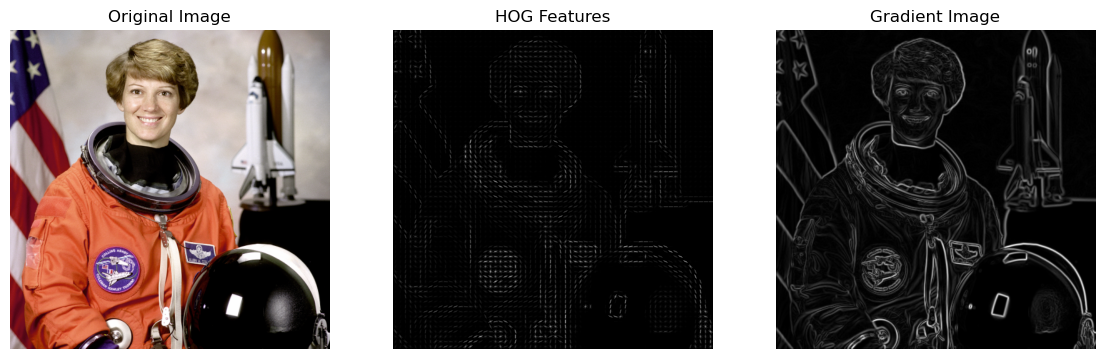

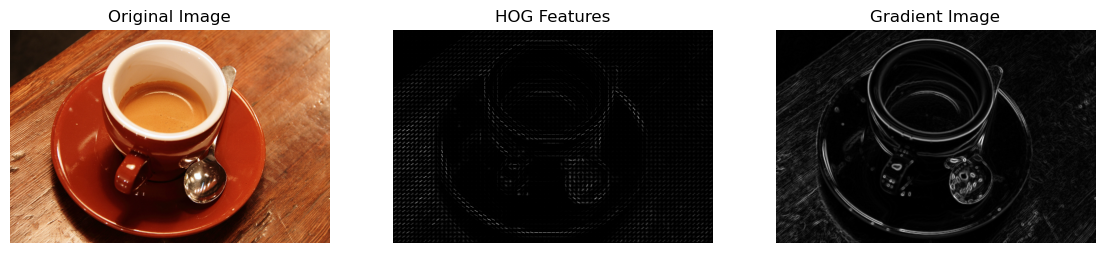

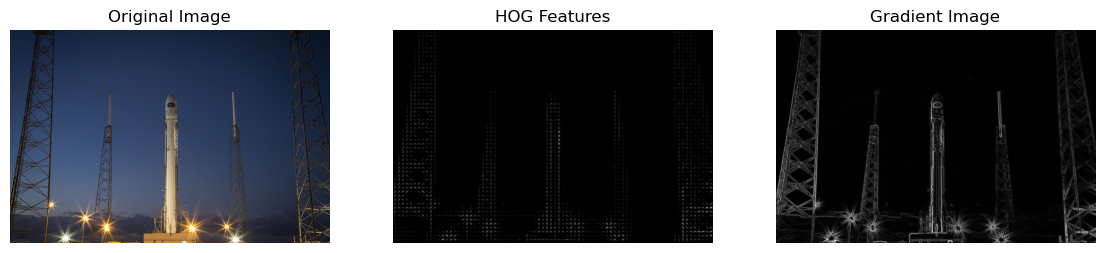

In [27]:
def compute_hog_features(original_image):
    gray_image = color.rgb2gray(original_image)

    # Compute HOG features
    return hog (
        gray_image, 
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(1, 1), 
        visualize=True, 
    )

def compute_gradient_image(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute gradients
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    
    # Combine gradients
    gradient_image = cv2.magnitude(grad_x, grad_y)
    
    return gradient_image

images = [data.astronaut(), data.coffee(), data.rocket()]

for img in images:
    _, hog_image = compute_hog_features(img)
    gradients = compute_gradient_image(img)
    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(14, 10))

    # Plot original image
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot HOG image
    axes[1].imshow(hog_image, cmap='grey')
    axes[1].set_title('HOG Features')
    axes[1].axis('off')

    # Plot HOG features
    axes[2].imshow(gradients, cmap='grey')
    axes[2].set_title('Gradient Image')
    axes[2].axis('off')
    plt.show()

**Compare the HOG features extracted from different images. Discuss the impact of varying parameters like cell size, block size, and the number of bins on the resulting HOG descriptors**

**1. Cell size** is the dimensions of the pixel regions over which gradient histograms are computed. Smaller cell size results in more sensitive features capturing finer details and local variations in the image, while larger cell size focuses more on prominent features. Larger cell size might miss subtle gradients and therefore miss important spatial information.

**2. Block Size** Smaller block size allows for finer normalization of features and helps emphasizing local changes. Larger block size provides more global normalization across features and can improve robustness against illumination changes. If block is too large this may blur important local features and reduce the ability to distinguish between classes.

**3. Number of Bins** Many bins increases the of the orientation information allowing more precise feature extraction. Fewer bins reduces model complexity and the risk of overfitting and leads to a loss of fine directional information, as it might not accurately capture edge orientation, leading to reduced discriminative ability.

---
## **Local Binary Patterns (LBP) (13 points)**

**Write a Python function to compute the LBP of a given grayscale image. Use the basic 8-neighbor LBP method. Compute the histograms on minimum three different images**

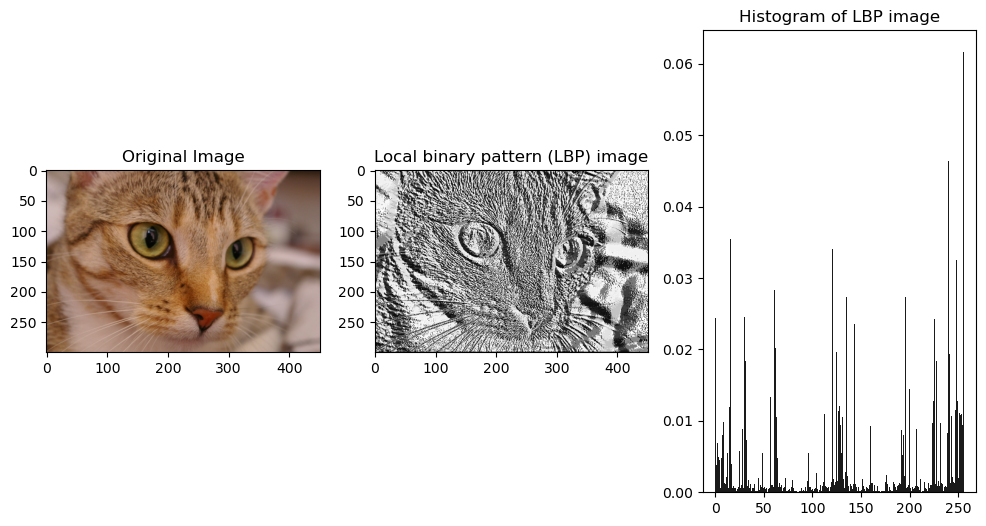

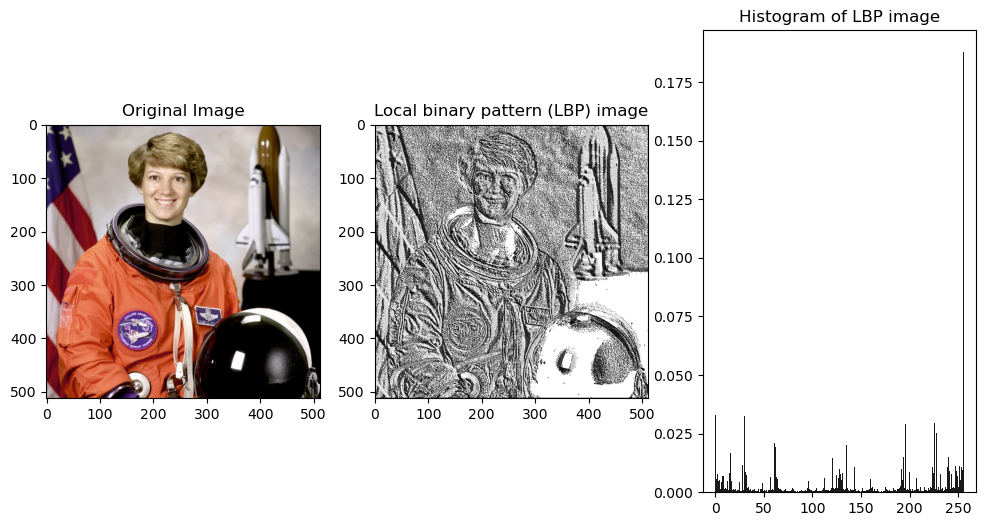

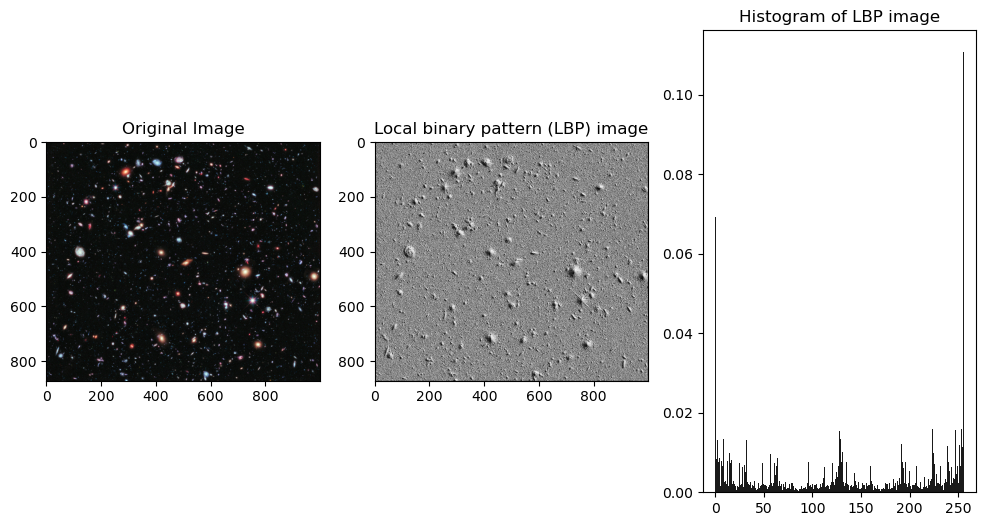

In [28]:
# local Binary Patterns
def get_pixel(img, center, x, y):
    new_value = 0
      
    try:
        # If local neighbourhood pixel value is greater than or equal
        # to center pixel values then set it to 1
        if img[x][y] >= center:
            new_value = 1      
    except:
        # Exception is required when neighbourhood value of a center
        # pixel value is null i.e. values present at boundaries.
        pass
      
    return new_value
   
def lbp_calculated_pixel(img, x, y):
   
    center = img[x][y]
    val_ar = []
    val = 0.0

    # top_left
    val_ar.append(get_pixel(img, center, x-1, y-1))
      
    # top
    val_ar.append(get_pixel(img, center, x-1, y))
      
    # top_right
    val_ar.append(get_pixel(img, center, x-1, y + 1))
      
    # right
    val_ar.append(get_pixel(img, center, x, y + 1))
      
    # bottom_right
    val_ar.append(get_pixel(img, center, x + 1, y + 1))
      
    # bottom
    val_ar.append(get_pixel(img, center, x + 1, y))
      
    # bottom_left
    val_ar.append(get_pixel(img, center, x + 1, y-1))
      
    # left
    val_ar.append(get_pixel(img, center, x, y-1))
       
    # Convert binary values to decimal
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
   
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
          
    return val

def histo_gram(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return hist(
        lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')

images = [data.chelsea(), data.astronaut(), data.hubble_deep_field()]

for img in images:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = img_gray.shape
    lbp_img = np.zeros((height, width), np.uint8)
    
    for i in range(0, height):
        for j in range(0, width):
            lbp_img[i, j] = lbp_calculated_pixel(img_gray, i, j)

    hist, bin = np.histogram(lbp_img.ravel(), 256, [0,255])
    #histo = histo_gram(lbp_img)
    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    
    # Plot original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    #axes[0].axis('off')

    # Plot LBP image
    axes[1].imshow(lbp_img, cmap='grey')
    axes[1].set_title('Local binary pattern (LBP) image')
    #axes[1].axis('off')

    # Plot histogram
    n_bins = 256
    axes[2].hist(
        lbp_img.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.1')
    axes[2].set_title('Histogram of LBP image')
    #axes[2].axis('off')

    plt.show()

**Explain what the histogram represents in terms of the texture features of the image**
<br>
In general terms the histogram of local binary pattern images (LBP) captures the frequency of occurence of different patterns and textures in the image. Textures with distinct patterns will result in histograms with prominent peaks at specific LBP values, while homogeneous textures result in more uniform histograms. It can highlight features like spots, line endings, edges and corners. Thus by comparing histograms from different images we can assess similarities and differences in texture, which is useful in say face recognition and texture classification. The local binary pattern algorithm is usually a pre-processing stage where its output becomes the input data for some machine learning model, such as support vector machines (SVM). Using the basic LBP method of 8 surrounding pixels we have a total of $2^8=256$ possible combinations of LBP codes, thus a 256-bin histogram is sufficient to assess the final LBP-codes feature vector.

**Compare and discuss differences in histograms and what they tell you about the textures of he three LBP images**
<br>
The LBP histograms of the astronaut and universe images are somewhat different from the cat image. The cat image shows a LBP histogram with many distinct spikes, while the two others images have more uniform distrubutions. This cat photo has many close up and distinct visual features with its striped fur, which may explain the spiky histogram. The female astronaut image contains many large areas of monotone colors black, white and orange, and may explain why the corresponding histogram has fewer and smaller spikes. We see similar uniform LBP histogram for the Hubble deep field image which is fairly even in color/intensity as it is largely black background, the LBP code around zero as the most prominent peak, zero means the darkest shade of gray (black) and represent featureless content of the image. It should be noted that experimenting with different number of bins the resulting histograms will change characteristics accordingly. 

---
## **Implement a blob detection algorithm (15 points)**

In [5]:
# TODO

---
## **Implement a contour detection algorithm (15 points)**

In [7]:
# TODO